# **Time Series Regression Analysis**

## **<span style="color: blue;">Business Understanding</span>**

The main objective is to build a model that accurately predicts unit sales for thousands of products across different Favorita store locations. This will help ensure optimal inventory management, reduce waste, and improve operational efficiency.

We have access to several datasets:

1. Training data: Contains dates, store and product information, promotions, and sales figures.
2. Store metadata: Includes cluster, type, city, and state information.
3. Oil price data: Daily oil prices for the relevant time period.
4. Transactions data: Daily transaction counts for each store.

Key features include:

1. store_nbr: Identifies the store location
2. family: Product category
3. sales: Total sales for a product family at a specific store on a given date
4. onpromotion: Number of items in a product family on promotion

### **Hypothesis**

**Null Hypothesis (H0):**

Promotional activities (as measured by the 'onpromotion' variable) have no significant effect on the daily sales of products across Favorita stores.

Mathematically, we can express this as:
        
H0: β = 0

Where β is the coefficient of the 'onpromotion' variable in our predictive model.

**Alternative Hypothesis (H1):**

Promotional activities have a significant effect on the daily sales of products across Favorita stores.

Mathematically, we can express this as:

H1: β ≠ 0

### **Analytical Questions**

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

## **<span style="color: blue;">Data Understanding</span>**

### **<span style="color: skyblue;">Importation</span>**

**Importation of all necessary packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Dataset Importation & Loading**

In [2]:
# Connect to the Database Using "pyodbc"
import pyodbc
print("pyodbc is installed and imported successfully")

import pyodbc
from dotenv import dotenv_values    #import the dotenv_values function from the dotenv package
import pandas as pd
import warnings 

warnings.filterwarnings('ignore')

# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials set in the '.env' file
server = environment_variables.get("SERVER_NAME")
database = environment_variables.get("DATABASE_NAME")
login = environment_variables.get("LOGIN")
password = environment_variables.get("PASSWORD")

pyodbc is installed and imported successfully


In [3]:
# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={login};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"


In [4]:
# connect to the Database
connection = pyodbc.connect(connection_string)
print("Connection successful")

Connection successful


In [5]:
# Query the Sql Database
query = "SELECT * FROM dbo.oil"

# Execute the query and read the results into a DataFrame
oil = pd.read_sql(query, connection)

In [6]:
# Query the Sql Database
query = "SELECT * FROM dbo.holidays_events"

# Execute the query and read the results into a DataFrame
holidays_events = pd.read_sql(query, connection)

In [7]:
# Query the Sql Database
query = "SELECT * FROM dbo.stores"

# Execute the query and read the results into a DataFrame
stores = pd.read_sql(query, connection)

In [8]:
sample_submission = pd.read_csv('../Data/sample_submission.csv')

In [9]:
test = pd.read_csv('../Data/test.csv')

In [10]:
train = pd.read_csv('../Data/train.csv')

In [11]:
transactions = pd.read_csv('../Data/transactions.csv')

### **<span style="color: skyblue;">Exploratory Data Analysis</span>**

#### train data

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [13]:
# Convert date to datetime format

train['date'] = pd.to_datetime(train['date'])

In [14]:
# Create additional time-based features

train['day_of_week'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['weekend'] = train['day_of_week'].isin([5, 6]).astype(int)


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   day_of_week  int32         
 7   month        int32         
 8   year         int32         
 9   weekend      int64         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(4), object(1)
memory usage: 194.6+ MB


In [16]:
train.describe().T

,count,mean,min,25%,50%,75%,max,std
id,3000888.0,1500443.5,0.0,750221.75,1500443.5,2250665.25,3000887.0,866281.891642
date,3000888,2015-04-24 08:27:04.703088384,2013-01-01 00:00:00,2014-02-26 18:00:00,2015-04-24 12:00:00,2016-06-19 06:00:00,2017-08-15 00:00:00,NaN
store_nbr,3000888.0,27.5,1.0,14.0,27.5,41.0,54.0,15.585787
sales,3000888.0,357.775749,0.0,0.0,11.0,195.84725,124717.0,1101.997721
onpromotion,3000888.0,2.60277,0.0,0.0,0.0,0.0,741.0,12.218882
day_of_week,3000888.0,2.997031,0.0,1.0,3.0,5.0,6.0,2.00074
month,3000888.0,6.207838,1.0,3.0,6.0,9.0,12.0,3.385668
year,3000888.0,2014.837886,2013.0,2014.0,2015.0,2016.0,2017.0,1.345518
weekend,3000888.0,0.285629,0.0,0.0,0.0,1.0,1.0,0.451714


In [17]:
train.isnull().sum().sum()

np.int64(0)

In [18]:
train.duplicated().sum().sum()

np.int64(0)

In [19]:
# Calculate the correlation matrix

numeric_columns = train.select_dtypes(include=['int32', 'int64', 'float64']).columns

correlation_matrix = train[numeric_columns].corr()

correlation_matrix


,id,store_nbr,sales,onpromotion,day_of_week,month,year,weekend
id,1.000000,3.013308e-04,0.085784,0.206260,-1.561462e-03,6.743357e-02,9.776028e-01,-1.554931e-04
store_nbr,0.000301,1.000000e+00,0.041196,0.007286,5.272840e-17,-4.946280e-15,8.754910e-15,4.390413e-17
sales,0.085784,4.119605e-02,1.000000,0.427923,3.686897e-02,1.978967e-02,8.109275e-02,5.187378e-02
onpromotion,0.206260,7.285647e-03,0.427923,1.000000,-2.696396e-03,2.588107e-02,1.990601e-01,-2.959044e-02
day_of_week,-0.001561,5.272840e-17,0.036869,-0.002696,1.000000e+00,-5.607083e-03,-3.993864e-04,7.907226e-01
month,0.067434,-4.946280e-15,0.019790,0.025881,-5.607083e-03,1.000000e+00,-1.432929e-01,-7.650410e-04
year,0.977603,8.754910e-15,0.081093,0.199060,-3.993864e-04,-1.432929e-01,1.000000e+00,-2.262704e-05
weekend,-0.000155,4.390413e-17,0.051874,-0.029590,7.907226e-01,-7.650410e-04,-2.262704e-05,1.000000e+00


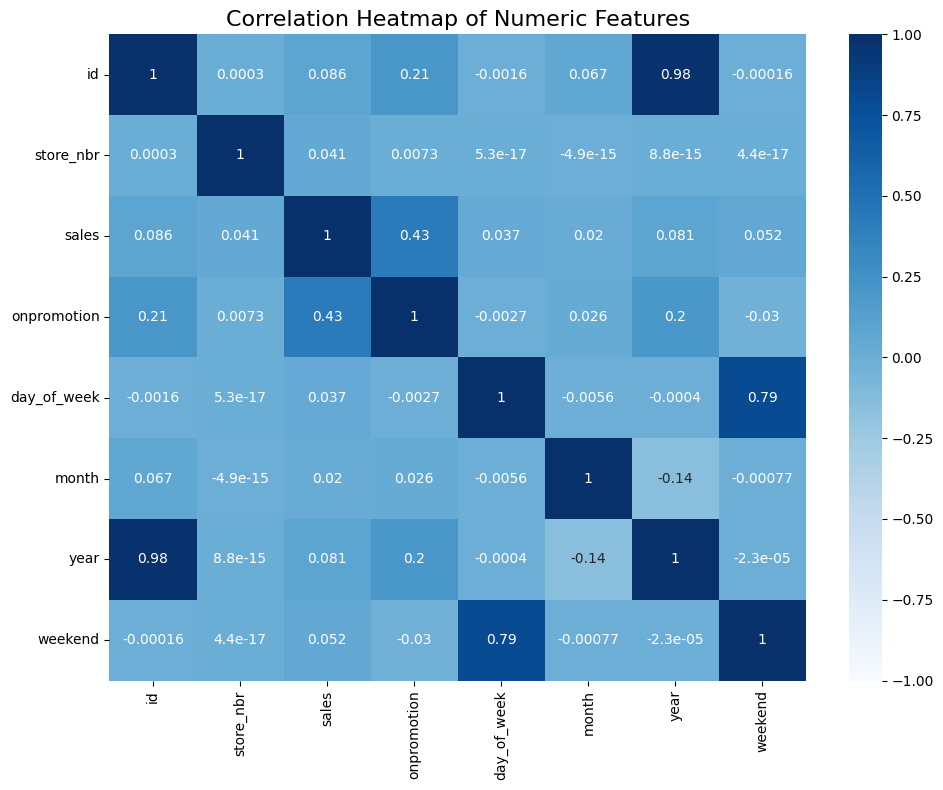

In [20]:
# plot the correlation matric

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()

1. Strong Correlations:

id and year (0.977603): This extremely high correlation suggests that the id is likely a time-based identifier, increasing with the year.

day_of_week and weekend (0.790723): This strong positive correlation is expected, as weekends are a subset of days of the week.

2. Moderate Correlations:

sales and onpromotion (0.427923): This positive correlation suggests that items on promotion tend to have higher sales.

id and onpromotion (0.206260): There's a weak to moderate positive correlation, which might indicate that promotions have increased over time.

3. Weak Correlations:

sales and id (0.085784): A weak positive correlation, possibly indicating a slight increase in sales over time.

sales and year (0.081093): Similar to the id correlation, suggesting a slight upward trend in sales over the years.

sales and weekend (0.051874): A very weak positive correlation, indicating slightly higher sales on weekends.

4. No Significant Correlations:

store_nbr shows very weak or no correlation with other variables, suggesting that the store number doesn't significantly impact other factors.

month shows very weak correlations with other variables, indicating that the month of the year doesn't strongly influence sales or other factors.

#### test data

In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [22]:
# Convert date to datetime format

test['date'] = pd.to_datetime(test['date'])

In [23]:
# Create additional time-based features

test['day_of_week'] = test['date'].dt.dayofweek
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year
test['weekend'] = test['day_of_week'].isin([5, 6]).astype(int)


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
 5   day_of_week  28512 non-null  int32         
 6   month        28512 non-null  int32         
 7   year         28512 non-null  int32         
 8   weekend      28512 non-null  int64         
dtypes: datetime64[ns](1), int32(3), int64(4), object(1)
memory usage: 1.6+ MB


In [25]:
# checking for missing values

test.isnull().sum().sum()

np.int64(0)

In [26]:
# Check for dublicates

test.duplicated().sum().sum()

np.int64(0)

In [27]:
test.describe().T

,count,mean,min,25%,50%,75%,max,std
id,28512.0,3015143.5,3000888.0,3008015.75,3015143.5,3022271.25,3029399.0,8230.849774
date,28512,2017-08-23 12:00:00,2017-08-16 00:00:00,2017-08-19 18:00:00,2017-08-23 12:00:00,2017-08-27 06:00:00,2017-08-31 00:00:00,NaN
store_nbr,28512.0,27.5,1.0,14.0,27.5,41.0,54.0,15.586057
onpromotion,28512.0,6.965383,0.0,0.0,0.0,6.0,646.0,20.683952
day_of_week,28512.0,2.9375,0.0,1.75,3.0,4.25,6.0,1.886457
month,28512.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0
year,28512.0,2017.0,2017.0,2017.0,2017.0,2017.0,2017.0,0.0
weekend,28512.0,0.25,0.0,0.0,0.0,0.25,1.0,0.43302


#### **transactions data**

This dataset can provide valuable information about overall store activity

In [28]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [29]:
# Convert the date columns into datetime format

transactions['date'] = pd.to_datetime(transactions['date'])

In [30]:
# Sort the transactions dataframe by store_nbr and date

transactions = transactions.sort_values(['store_nbr', 'date'])

In [31]:
# # Function to create rolling average features (to smooth out short-term fluctuations and highlight longer-term trends)
# def create_rolling_features(df):
#     df['rolling_avg_7d'] = df.groupby('store_nbr')['transactions'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
#     df['rolling_avg_30d'] = df.groupby('store_nbr')['transactions'].rolling(window=30, min_periods=1).mean().reset_index(0, drop=True)
#     return df

In [32]:
# transactions = create_rolling_features(transactions)

In [33]:
# Check the date ranges of your datasets

print("Train date range:", train['date'].min(), "to", train['date'].max())
print("Test date range:", test['date'].min(), "to", test['date'].max())
print("Transactions date range:", transactions['date'].min(), "to", transactions['date'].max())


Train date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Test date range: 2017-08-16 00:00:00 to 2017-08-31 00:00:00
Transactions date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00


There is a mismatch between the transactions dataset and the test dataset. The transactions data ends on 2017-08-15, while the test data goes up to 2017-08-31. This will indeed cause NaN values when we try to merge the datasets. We would estimate transaction data for the missing test dates based on historical data. This involves creating synthetic transaction data for the test period based on trends observed in the training data.

In [34]:
# Identify missing dates in transactions for the test period

last_transaction_date = transactions['date'].max()
test_start_date = test['date'].min()
test_end_date = test['date'].max()

In [35]:
# Create a date range for the missing dates

if last_transaction_date < test_end_date:
    missing_dates = pd.date_range(start=last_transaction_date + pd.Timedelta(days=1), end=test_end_date)

In [36]:
# Get unique store numbers

stores = transactions['store_nbr'].unique()

In [37]:
# Create a DataFrame for the missing dates

missing_df = pd.DataFrame([(date, store) for date in missing_dates for store in stores], 
                              
                              columns=['date', 'store_nbr'])


In [38]:
# Function to estimate transactions for a store on a given date
def estimate_transactions(group):
    # Use the mean of the last available transactions for the same weekday
        last_date = group['date'].max()
        weekday = last_date.weekday()
        historical_same_weekday = group[group['date'].dt.weekday == weekday]
        return historical_same_weekday['transactions'].mean() if not historical_same_weekday.empty else 0

In [39]:
# Estimate transactions for missing dates

for store in stores:
        store_data = transactions[transactions['store_nbr'] == store]
        estimated_value = estimate_transactions(store_data)
        missing_df.loc[missing_df['store_nbr'] == store, 'transactions'] = estimated_value

In [40]:
# Concatenate the original and estimated transactions

transaction_data = pd.concat([transactions, missing_df], ignore_index=True)


In [41]:
# Sort the dataframe

transaction_data = transaction_data.sort_values(['store_nbr', 'date'])

In [42]:
# Create rolling features
def create_rolling_features(df):
    df['rolling_avg_7d'] = df.groupby('store_nbr')['transactions'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
    df['rolling_avg_30d'] = df.groupby('store_nbr')['transactions'].rolling(window=30, min_periods=1).mean().reset_index(0, drop=True)
    return df

transaction_data = create_rolling_features(transaction_data)


In [43]:
transaction_data.tail()

,date,store_nbr,transactions,rolling_avg_7d,rolling_avg_30d
84135,2017-08-27,54,817.721992,817.721992,833.222130
84189,2017-08-28,54,817.721992,817.721992,831.479530
84243,2017-08-29,54,817.721992,817.721992,821.803596
84297,2017-08-30,54,817.721992,817.721992,820.394329
84351,2017-08-31,54,817.721992,817.721992,819.618396


In [44]:
transaction_data.isnull().sum().sum()

np.int64(0)

In [45]:
transaction_data.duplicated().sum()

np.int64(0)

In [46]:
# Merge with train and test datasets

train_data = pd.merge(train, transaction_data, on=['date', 'store_nbr'], how='left')

test_data = pd.merge(test, transaction_data, on=['date', 'store_nbr'], how='left')


In [47]:
# Check for any remaining NaN values

print("Missing values in train set:", train_data.isnull().sum())
print("Missing values in test set:", test_data.isnull().sum())

Missing values in train set: id                      0
date                    0
store_nbr               0
family                  0
sales                   0
onpromotion             0
day_of_week             0
month                   0
year                    0
weekend                 0
transactions       245784
rolling_avg_7d     245784
rolling_avg_30d    245784
dtype: int64
Missing values in test set: id                 0
date               0
store_nbr          0
family             0
onpromotion        0
day_of_week        0
month              0
year               0
weekend            0
transactions       0
rolling_avg_7d     0
rolling_avg_30d    0
dtype: int64


The problem likely stems from dates in the train set that are not present in the transactions dataset. Step-by-step approach to address this:

In [48]:
# Identify the missing dates in the train set

missing_dates = train_data[train_data['transactions'].isnull()]['date'].unique()
print(f"Number of unique missing dates: {len(missing_dates)}")
print("Sample of missing dates:", missing_dates[:5])  # Print first 5 as an example



Number of unique missing dates: 1566
Sample of missing dates: <DatetimeArray>
['2013-01-01 00:00:00', '2013-01-02 00:00:00', '2013-01-03 00:00:00',
 '2013-01-04 00:00:00', '2013-01-05 00:00:00']
Length: 5, dtype: datetime64[ns]


In [49]:
# Create a complete transactions dataset that covers all dates in both train and test sets

# Get the full date range
all_dates = pd.date_range(start=min(train['date'].min(), transactions['date'].min()),
                          end=max(train['date'].max(), test['date'].max()))

# Get all unique store numbers
all_stores = transactions['store_nbr'].unique()

# Create a DataFrame with all combinations of dates and stores
full_index = pd.MultiIndex.from_product([all_dates, all_stores], names=['date', 'store_nbr'])
full_transactions_df = pd.DataFrame(index=full_index).reset_index()

# Merge with the existing transactions data
full_transactions_df = pd.merge(full_transactions_df, transactions, on=['date', 'store_nbr'], how='left')

# Sort the dataframe
full_transactions_df = full_transactions_df.sort_values(['store_nbr', 'date'])




In [50]:
#Estimate missing transactions

def estimate_transactions(group):
    group = group.sort_values('date')
    group['transactions'] = group['transactions'].fillna(method='ffill')
    
    if group['transactions'].isnull().any():
        # If there are still NaNs, fill with the mean of the same weekday
        group['weekday'] = group['date'].dt.weekday
        group['transactions'] = group['transactions'].fillna(group.groupby('weekday')['transactions'].transform('mean'))
    
    # If there are still NaNs (e.g., for a new store), fill with overall mean
    group['transactions'] = group['transactions'].fillna(group['transactions'].mean())
    
    return group

# Fill missing transactions
full_transactions_df = full_transactions_df.groupby('store_nbr').apply(estimate_transactions).reset_index(drop=True)


In [51]:
# Create rolling features

def create_rolling_features(df):
    df = df.sort_values(['store_nbr', 'date'])
    df['rolling_avg_7d'] = df.groupby('store_nbr')['transactions'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
    df['rolling_avg_30d'] = df.groupby('store_nbr')['transactions'].rolling(window=30, min_periods=1).mean().reset_index(0, drop=True)
    return df

full_transactions_df = create_rolling_features(full_transactions_df)

full_transactions_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             92016 non-null  datetime64[ns]
 1   store_nbr        92016 non-null  int64         
 2   transactions     92016 non-null  float64       
 3   weekday          90312 non-null  float64       
 4   rolling_avg_7d   92016 non-null  float64       
 5   rolling_avg_30d  92016 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 4.2 MB


In [52]:
# Merge with train and test datasets

train_merged = pd.merge(train, full_transactions_df, on=['date', 'store_nbr'], how='left')
test_merged = pd.merge(test, full_transactions_df, on=['date', 'store_nbr'], how='left')


In [53]:
# Recheck for missing values

print("Missing values in train set:", train_merged.isnull().sum())
print("Missing values in test set:", test_merged.isnull().sum())


Missing values in train set: id                     0
date                   0
store_nbr              0
family                 0
sales                  0
onpromotion            0
day_of_week            0
month                  0
year                   0
weekend                0
transactions           0
weekday            55572
rolling_avg_7d         0
rolling_avg_30d        0
dtype: int64
Missing values in test set: id                   0
date                 0
store_nbr            0
family               0
onpromotion          0
day_of_week          0
month                0
year                 0
weekend              0
transactions         0
weekday            528
rolling_avg_7d       0
rolling_avg_30d      0
dtype: int64


The main issue we had with missing transaction data has been resolved. However, we now have missing values in the 'weekday' column for both train and test sets. To resove this, the 'weekday' column would be removed since this column was only used for estimation and is causing issues in the merged datasets.

In [54]:
# Remove the 'weekday' column from full_transactions_df
full_transactions_df = full_transactions_df.drop(columns=['weekday'])

# Merge again with train and test datasets
train_merged = pd.merge(train, full_transactions_df, on=['date', 'store_nbr'], how='left')
test_merged = pd.merge(test, full_transactions_df, on=['date', 'store_nbr'], how='left')

# Final check for missing values
print("Missing values in train set:", train_merged.isnull().sum())
print("Missing values in test set:", test_merged.isnull().sum())



Missing values in train set: id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
day_of_week        0
month              0
year               0
weekend            0
transactions       0
rolling_avg_7d     0
rolling_avg_30d    0
dtype: int64
Missing values in test set: id                 0
date               0
store_nbr          0
family             0
onpromotion        0
day_of_week        0
month              0
year               0
weekend            0
transactions       0
rolling_avg_7d     0
rolling_avg_30d    0
dtype: int64


In [55]:
# Check if all necessary columns are present

print("\nColumns in train_merged:", train_merged.columns)
print("\nColumns in test_merged:", test_merged.columns)




Columns in train_merged: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'day_of_week', 'month', 'year', 'weekend', 'transactions',
       'rolling_avg_7d', 'rolling_avg_30d'],
      dtype='object')

Columns in test_merged: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'day_of_week',
       'month', 'year', 'weekend', 'transactions', 'rolling_avg_7d',
       'rolling_avg_30d'],
      dtype='object')


The train_merged dataset includes the 'sales' column, which is expected since it's the target variable for training, while the test_merged dataset does not include 'sales', which is also expected.

In [57]:
# Display info about the final datasets

print("\nTrain set info:")
train_merged.info()




Train set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 13 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   date             datetime64[ns]
 2   store_nbr        int64         
 3   family           object        
 4   sales            float64       
 5   onpromotion      int64         
 6   day_of_week      int32         
 7   month            int32         
 8   year             int32         
 9   weekend          int64         
 10  transactions     float64       
 11  rolling_avg_7d   float64       
 12  rolling_avg_30d  float64       
dtypes: datetime64[ns](1), float64(4), int32(3), int64(4), object(1)
memory usage: 263.3+ MB


In [58]:
print("\nTest set info:")
test_merged.info()


Test set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               28512 non-null  int64         
 1   date             28512 non-null  datetime64[ns]
 2   store_nbr        28512 non-null  int64         
 3   family           28512 non-null  object        
 4   onpromotion      28512 non-null  int64         
 5   day_of_week      28512 non-null  int32         
 6   month            28512 non-null  int32         
 7   year             28512 non-null  int32         
 8   weekend          28512 non-null  int64         
 9   transactions     28512 non-null  float64       
 10  rolling_avg_7d   28512 non-null  float64       
 11  rolling_avg_30d  28512 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(3), int64(4), object(1)
memory usage: 2.3+ MB


#### **stores data**

This metadata can help in understanding store-specific patterns.

In [61]:
stores

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

In [63]:
# Convert the stores array to a DataFrame

stores_df = pd.DataFrame(stores, columns=['store_nbr'])

In [64]:
# Merge the stores DataFrame with the train and test DataFrames

train_merged_st = pd.merge(train_merged, stores_df, on='store_nbr', how='inner')
test_merged_st = pd.merge(test_merged, stores_df, on='store_nbr', how='inner')

In [65]:
# Display info about the final datasets
print("\nTrain set info:")
train_merged_st.info()


Train set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 13 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   date             datetime64[ns]
 2   store_nbr        int64         
 3   family           object        
 4   sales            float64       
 5   onpromotion      int64         
 6   day_of_week      int32         
 7   month            int32         
 8   year             int32         
 9   weekend          int64         
 10  transactions     float64       
 11  rolling_avg_7d   float64       
 12  rolling_avg_30d  float64       
dtypes: datetime64[ns](1), float64(4), int32(3), int64(4), object(1)
memory usage: 263.3+ MB


In [67]:
print("\nTest set info:")
test_merged_st.info()


Test set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               28512 non-null  int64         
 1   date             28512 non-null  datetime64[ns]
 2   store_nbr        28512 non-null  int64         
 3   family           28512 non-null  object        
 4   onpromotion      28512 non-null  int64         
 5   day_of_week      28512 non-null  int32         
 6   month            28512 non-null  int32         
 7   year             28512 non-null  int32         
 8   weekend          28512 non-null  int64         
 9   transactions     28512 non-null  float64       
 10  rolling_avg_7d   28512 non-null  float64       
 11  rolling_avg_30d  28512 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(3), int64(4), object(1)
memory usage: 2.3+ MB


In [69]:
train_merged_st.head()

,id,date,store_nbr,family,sales,onpromotion,day_of_week,month,year,weekend,transactions,rolling_avg_7d,rolling_avg_30d
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,2013,0,1742.300412,1742.300412,1742.300412
1,1,2013-01-01,1,BABY CARE,0.0,0,1,1,2013,0,1742.300412,1742.300412,1742.300412
2,2,2013-01-01,1,BEAUTY,0.0,0,1,1,2013,0,1742.300412,1742.300412,1742.300412
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,1,2013,0,1742.300412,1742.300412,1742.300412
4,4,2013-01-01,1,BOOKS,0.0,0,1,1,2013,0,1742.300412,1742.300412,1742.300412
